# Lesson (Exercises Below)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from env import username, password, host

#Stats imports & evaluations
from scipy import stats
import math

In [5]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()


,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13974 entries, 0 to 13973
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13974 non-null  object
 1   timestamp       13974 non-null  object
 2   request_method  13974 non-null  object
 3   request_path    13974 non-null  object
 4   http_version    13974 non-null  object
 5   status_code     13974 non-null  object
 6   size            13974 non-null  int64 
 7   user_agent      13974 non-null  object
dtypes: int64(1), object(7)
memory usage: 873.5+ KB


In [7]:
# Value Counts
df.ip.value_counts().head()

97.105.19.58      11998
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
Name: ip, dtype: int64

In [8]:
# Value Counts in percent
df.ip.value_counts(normalize=True).head()

97.105.19.58      0.858595
173.173.113.51    0.075784
72.181.113.170    0.043867
72.181.105.81     0.017604
24.26.242.9       0.001503
Name: ip, dtype: float64

In [9]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame: # Arrow notation is just another 
                                                                             # way to document code
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )


In [10]:
ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()


,count,proba
97.105.19.58,11998,0.858595
173.173.113.51,1059,0.075784
72.181.113.170,613,0.043867
72.181.105.81,246,0.017604
24.26.242.9,21,0.001503


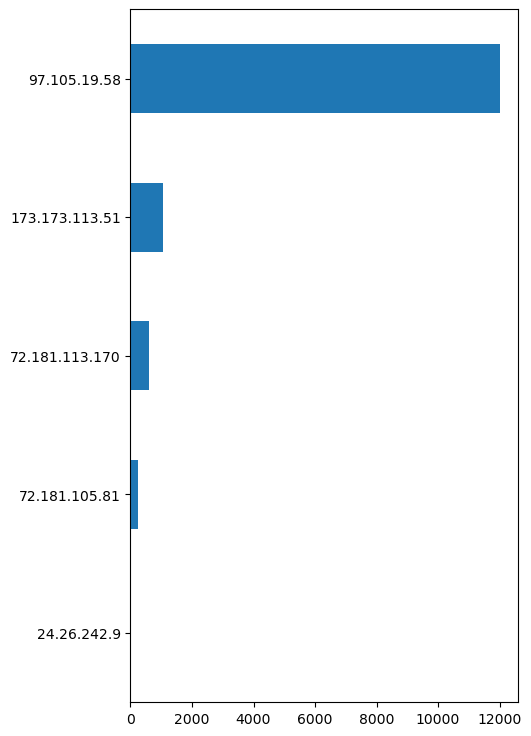

In [12]:
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))
plt.show()


In [13]:
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.head()


,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [14]:
# Looking for status codes not equal to 200. Errors
status_given_ip[status_given_ip.status_code != '200']


,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
20,97.105.19.58,499,0.001167


# Exercises

## Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

In [16]:
status_given_ip.groupby('ip').value_counts()

ip              status_code  proba_status_given_ip
173.173.113.51  200          1.000000                 1
24.26.242.9     200          1.000000                 1
3.88.129.158    200          1.000000                 1
3.92.201.136    200          1.000000                 1
34.207.64.242   200          1.000000                 1
34.229.70.250   200          1.000000                 1
35.174.209.2    200          1.000000                 1
35.175.171.137  200          1.000000                 1
45.23.250.16    200          1.000000                 1
52.87.230.102   200          1.000000                 1
52.90.165.200   200          1.000000                 1
52.91.30.150    200          1.000000                 1
54.145.52.184   200          1.000000                 1
54.172.14.223   200          1.000000                 1
68.201.219.223  200          1.000000                 1
70.121.214.34   200          1.000000                 1
72.181.105.81   200          1.000000                

**Both ip addresses that received a code 499 have gotten the green light 200 before**

In [19]:
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


### Request Method

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13974 entries, 0 to 13973
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13974 non-null  object
 1   timestamp       13974 non-null  object
 2   request_method  13974 non-null  object
 3   request_path    13974 non-null  object
 4   http_version    13974 non-null  object
 5   status_code     13974 non-null  object
 6   size            13974 non-null  int64 
 7   user_agent      13974 non-null  object
dtypes: int64(1), object(7)
memory usage: 873.5+ KB


In [20]:
df.request_method.value_counts()

GET    13974
Name: request_method, dtype: int64

### Size

In [26]:
df['size'].value_counts().sort_values(ascending=False).head()

494819    705
3561      548
3659      291
1328      229
1787      219
Name: size, dtype: int64

**494k is a large amount of data. Look into it.**

In [63]:
df[df['size'] > 400000]['ip'].value_counts()

97.105.19.58      10810
173.173.113.51      811
72.181.113.170      505
72.181.105.81       185
24.26.242.9           7
52.87.230.102         1
Name: ip, dtype: int64

In [67]:
# Hosts with over 400k size data requests.
hosts_over_400k = pd.DataFrame(df[df['size'] > 400000])
hosts_over_400k.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0
6,97.105.19.58,16/Apr/2019 19:34:50,GET,/api/v1/sales?page=85,HTTP/1.1,200,510753,python-requests/2.21.0


**Majority of large data requests are coming from one IP address. Host 58 seems suspicious.**

In [40]:
# Host 58 has a lot of large data requests
df[df['ip'] == '97.105.19.58']['size'].sort_values(ascending=False).value_counts()

494819    694
3561      408
493905    184
3659      179
1328      159
         ... 
278377      1
327529      1
343913      1
360297      1
126         1
Name: size, Length: 186, dtype: int64

In [42]:
# Host 58 largest data requests
df[df['ip'] == '97.105.19.58']['size'].sort_values(ascending=False)

3695     513736
5937     513736
5924     513736
10370    513736
9371     513736
          ...  
8267          0
5520          0
4790          0
8866          0
6934          0
Name: size, Length: 11998, dtype: int64

In [35]:
# Value counts in percent
df[df['ip'] == '97.105.19.58']['size'].value_counts(normalize=True).sort_values(ascending=False)

494819    0.057843
3561      0.034006
493905    0.015336
3659      0.014919
1328      0.013252
            ...   
126       0.000083
327529    0.000083
360297    0.000083
278377    0.000083
343913    0.000083
Name: size, Length: 186, dtype: float64

In [45]:
host_fifty_eight = df[(df['ip'] == '97.105.19.58') & (df['size'] > 400000)]
host_fifty_eight.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0
6,97.105.19.58,16/Apr/2019 19:34:50,GET,/api/v1/sales?page=85,HTTP/1.1,200,510753,python-requests/2.21.0


In [48]:
# Shape of df for host 58. Has over 10,000  requests of over 400,000 size.
host_fifty_eight.shape

(10810, 8)

In [49]:
# status code. All code 200. 
host_fifty_eight.status_code.value_counts()

200    10810
Name: status_code, dtype: int64

In [52]:
# All request paths are using an api for sales
host_fifty_eight.request_path.unique()

array(['/api/v1/sales?page=81', '/api/v1/sales?page=82',
       '/api/v1/sales?page=83', '/api/v1/sales?page=84',
       '/api/v1/sales?page=85', '/api/v1/sales?page=86', '/api/v1/sales',
       '/api/v1/sales?page=87', '/api/v1/sales?page=88',
       '/api/v1/sales?page=89', '/api/v1/sales?page=90',
       '/api/v1/sales?page=91', '/api/v1/sales?page=92',
       '/api/v1/sales?page=93', '/api/v1/sales?page=94',
       '/api/v1/sales?page=95', '/api/v1/sales?page=96',
       '/api/v1/sales?page=97', '/api/v1/sales?page=98',
       '/api/v1/sales?page=99', '/api/v1/sales?page=100',
       '/api/v1/sales?page=101', '/api/v1/sales?page=102',
       '/api/v1/sales?page=103', '/api/v1/sales?page=104',
       '/api/v1/sales?page=105', '/api/v1/sales?page=106',
       '/api/v1/sales?page=107', '/api/v1/sales?page=108',
       '/api/v1/sales?page=109', '/api/v1/sales?page=110',
       '/api/v1/sales?page=111', '/api/v1/sales?page=112',
       '/api/v1/sales?page=113', '/api/v1/sales?page=114',

In [54]:
host_fifty_eight.timestamp.sort_values()

0        16/Apr/2019 19:34:42
2        16/Apr/2019 19:34:44
3        16/Apr/2019 19:34:46
4        16/Apr/2019 19:34:48
6        16/Apr/2019 19:34:50
                 ...         
13969    17/Apr/2019 12:55:12
13970    17/Apr/2019 12:55:12
13972    17/Apr/2019 12:55:13
13971    17/Apr/2019 12:55:13
13973    17/Apr/2019 12:55:14
Name: timestamp, Length: 10810, dtype: object

In [70]:
hosts_over_400k.user_agent.value_counts()

python-requests/2.21.0                                                                                                       10463
python-requests/2.20.1                                                                                                        1852
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                               2
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36        1
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                       1
Name: user_agent, dtype: int64